In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
from tqdm.notebook import trange, tqdm


import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model
from agi_news import AGI_News


learning_rate = 1e-4
nepochs = 1
batch_size = 32
max_len = 128
data_set_root = "datasets"

# We'll be using the AG News Dataset
# Which contains a short news article and a single label to classify the "type" of article
# Note that for torchtext these datasets are NOT Pytorch dataset classes "AG_NEWS" is a function that
# returns a Pytorch DataPipe!

# Pytorch DataPipes vvv
# https://pytorch.org/data/main/torchdata.datapipes.iter.html

# vvv Good Blog on the difference between DataSet and DataPipe
# https://medium.com/deelvin-machine-learning/comparison-of-pytorch-dataset-and-torchdata-datapipes-486e03068c58
dataset_train = AG_NEWS(root=data_set_root, split="train")
print(next(iter(dataset_train)))


main_dir = os.getcwd()

# Change the working directory to the main directory
os.chdir(main_dir)

train_data = AGI_News(data_set_root, data_split="train")
test_data = AGI_News(data_set_root, data_split="test")

print(len(train_data), len(test_data))


(3, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")
120000 120000


In [2]:
# Un-Comment to train sentence-piece model for tokenizer and vocab!

from torchtext.data.functional import generate_sp_model

with open(os.path.join(data_set_root, "datasets/AG_NEWS/train.csv")) as f:
    with open(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), "w") as f2:
        for i, line in enumerate(f):
            text_only = "".join(line.split(",")[1:])
            filtered = re.sub(r'\\|\\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' ')) # remove newline characters
            f2.write(filtered.lower() + "\n")

generate_sp_model(os.path.join(data_set_root, "datasets/AG_NEWS/data.txt"), 
                  vocab_size=20000, model_prefix='spm_ag_news')

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=datasets/datasets/AG_NEWS/data.txt --model_prefix=spm_ag_news --vocab_size=20000 --model_type=unigram
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: datasets/datasets/AG_NEWS/data.txt
  input_format: 
  model_prefix: spm_ag_news
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: 

In [3]:
data_loader_train = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8, drop_last=True)
# DataLoader for testing dataset
data_loader_test = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

In [4]:
sp_model = load_sp_model("spm_ag_news.model")

# Create a tokenizer using the loaded model
tokenizer = sentencepiece_tokenizer(sp_model)

# Iterate over tokens generated by the tokenizer
for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creat', 'ing']


In [5]:
def yield_tokens(file_path):
    with io.open(file_path, encoding = 'utf-8') as f:
        for line in f:
            yield line.split("\t")[0]

vocab = build_vocab_from_iterator(
    yield_tokens("spm_ag_news.vocab"),
    # Define special tokens with special_first=True to place them at the beginning of the vocabulary
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)

# Set default index for out-of-vocabulary tokens
vocab.set_default_index(vocab['<unk>'])

In [6]:
class TokenDrop(nn.Module):
    def __init__(self, prob =0.1, pad_token = 0, num_special =4):

        self.prob = prob
        self.pad_token = pad_token
        self.num_special = num_special

    def __call__(self, sample):
        mask = torch.bernoulli(self.prob*torch.ones_like(sample)).long()

        can_drop = (sample>= self.num_special).long()

        mask = mask*can_drop

        replace_with = (self.pad_token*torch.ones_like(sample)).long()

        sample_out = (1-mask) * sample +mask *replace_with

        return sample_out

In [7]:
train_transform = T.Sequential(
    T.SentencePieceTokenizer("spm_ag_news.model"),
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> token at the beginning of each sentence (index 1 in vocabulary)
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    # Add <eos> token at the end of each sentence (index 2 in vocabulary)
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)


# Define a transformation pipeline for generation (without truncation)
gen_transform = T.Sequential(
    # Tokenize sentences using pre-existing SentencePiece tokenizer model
    T.SentencePieceTokenizer("spm_ag_news.model"),
    # Convert tokens to indices based on given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> token at the beginning of each sentence (index 1 in vocabulary)
    T.AddToken(1, begin=True),
    # Convert the list of lists to a tensor and pad sentences with the <pad> token if shorter than max length
    T.ToTensor(padding_value=0)
)

In [8]:
text = next(iter(data_loader_train))

index =0
input_tokens = train_transform(text)
print("Sentence")
print(text[index])
print("Tokens")
print(vocab.lookup_tokens(input_tokens[index].numpy()))

Sentence
middle east approaches that won #39;t work : brent scowcroft #39;s nov. 12 op-ed column,  quot;a middle east opening, quot; was a reminder of the middle east policy that failed the first george bush and his successor, bill clinton.
Tokens
['<sos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 't', '<unk>', '<unk>', '<unk>', '<unk>', 'w', '<unk>', '<unk>', 't', '<unk>', '<unk>', '<unk>', 's', '<unk>', '.', '<unk>', '<unk>', '-', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 'a', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

In [9]:
print("Tokens back to Sentence")

pred_text = "".join(vocab.lookup_tokens(input_tokens[index].numpy()))
pred_text.replace("_", " ")

Tokens back to Sentence


'<sos><unk><unk><unk><unk><unk><unk><unk><unk>t<unk><unk><unk><unk>w<unk><unk>t<unk><unk><unk>s<unk>.<unk><unk>-<unk><unk><unk><unk><unk>a<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>.<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [10]:
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers, emb_size = 128, hidden_size = 128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(num_emb, emb_size)

        self.mlp_emb = nn.Sequential(nn.Linear(emb_size, emb_size),
                                        nn.LayerNorm(emb_size),
                                        nn.ELU(),
                                        nn.Linear(emb_size, emb_size))

        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hidden_size,
        num_layers = num_layers, batch_first = True, dropout = 0.1)

        self.mlp_out = nn.Sequential(nn.Linear(hidden_size, hidden_size//2),
        nn.LayerNorm(hidden_size//2),
        nn.ELU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_size//2, num_emb))

    def forward(self, input_seq, hidden_in, mem_in):
        input_emb = self.embedding(input_seq)
        input_embs = self.mlp_emb(input_emb)
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
        return self.mlp_out(output), hidden_out, mem_out

In [11]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

emb_size = 256
hidden_size = 1024

num_layers = 2

lstm_generator = LSTM(num_emb= len(vocab), num_layers = num_layers,
emb_size = emb_size, hidden_size = hidden_size).to(device)

optimizer = optim.Adam(lstm_generator.parameters(), lr = learning_rate, weight_decay = 1e-4)

In [12]:
loss_fn = nn.CrossEntropyLoss()

# Custom transform that will randomly replace a token with <pad>
td = TokenDrop(prob=0.1)

# List to store training loss during each epoch
training_loss_logger = []

# List to store entropy during training (for monitoring)
entropy_logger = []

In [13]:
num_model_params = 0
for param in lstm_generator.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 14347318 (Approximately 14 Million) Parameters!


In [14]:
for epoch in trange(0,nepochs, leave = False, desc = "Epoch"):
    lstm_generator.train()
    steps =0

    for text in tqdm(data_loader_train, desc ="Training", leave = False):
        text_tokens = train_transform(list(text)).to(device)

        bs = text_tokens.shape[0]

        input_text = td(text_tokens[:,0:-1])
        output_text = (text_tokens[:,1:])

        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Forward pass through the LSTM generator
        pred, hidden, memory = lstm_generator(input_text, hidden, memory)


        loss = loss_fn(pred.transpose(1, 2), output_text)
        
        # Zero gradients, perform backward pass, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log training loss
        training_loss_logger.append(loss.item())
        
        # Log entropy during training (for monitoring)
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/3750 [00:00<?, ?it/s]

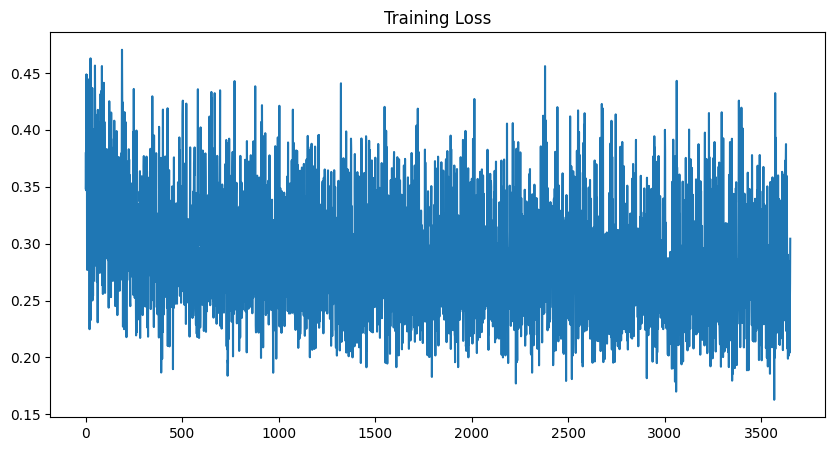

In [15]:
_= plt.figure(figsize=(10,5))
_= plt.plot(training_loss_logger[100:])
_=plt.title("Training Loss")

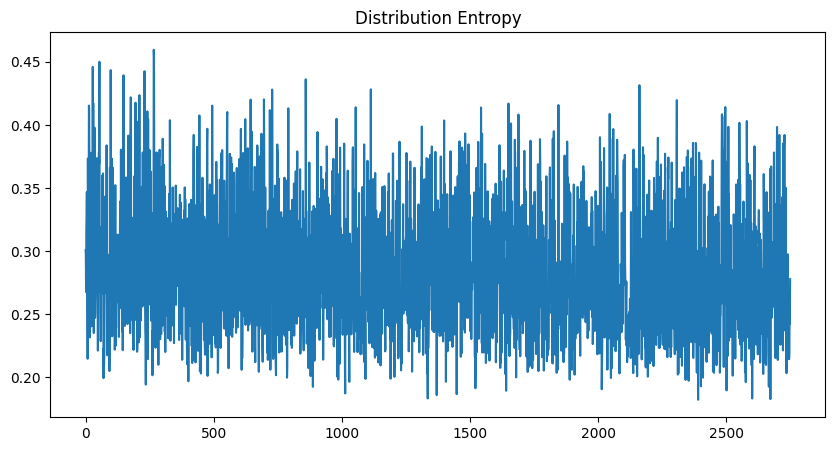

In [16]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[1000:])
_ = plt.title("Distribution Entropy")

In [ ]:

# Get some test examples
text = next(iter(data_loader_test))

In [17]:
index =0

temp =0.9

init_prompt = [text[index].split(":")[0] + ":"]

input_tokens = gen_transform(init_prompt).to(device)

print("Initial prompt:")
print(init_prompt[0])

print("\nPrompt tokens")
print(input_tokens)
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

Initial prompt:
teen flies in plane #39;s landing gear :

Prompt tokens
tensor([[ 1,  3,  3,  3,  3,  3,  3,  3, 10,  3,  3,  3]])
['<sos>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', 's', '<unk>', '<unk>', '<unk>']


In [18]:
log_tokens =[]

lstm_generator.eval()
with torch.no_grad():
    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)

    for i in range(100):
        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)

        dist = Categorical(logits = data_pred[:, -1]/temp)

        input_tokens = dist.sample().reshape(1,1)
        log_tokens.append(input_tokens.cpu())

        if input_tokens.item() == 2:
            break



In [19]:
pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))
print(pred_text)

<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>.<eos>


In [20]:
init_prompt[0] + pred_text.replace("_", " ").replace("<unk>", "")

'teen flies in plane #39;s landing gear :.<eos>'